# Libs

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Masking
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from WickelfeaturesProject.keras_metrics import KerasMetrics
from keras.optimizers import adam
import keras.backend as K
from sklearn.metrics import f1_score
from scipy.spatial import distance
import pickle
opt = adam()

Using TensorFlow backend.


# Data

corpus = pd.read_csv("WickelfeaturesProject/Corpus new coding/corpus_complete.csv", names=['verb0', 'inf_verb', 'conj_verb0', 'conj_verb'])

corpus.drop(['verb0','conj_verb0'], axis=1,inplace=True)

corpus['conj_verb'] = corpus.conj_verb.apply(lambda x: x.strip('#'))

corpus['inf_verb'] = corpus.inf_verb.apply(lambda x: x.strip('#'))

corpus.head()

corpus.to_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used', index=False)

corpus['conj_verb'] = corpus.conj_verb.apply(lambda x: '#'+x+ '$')

corpus.head()

In [2]:
#corpus.to_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used', index=False)

In [3]:
corpus = pd.read_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used')

# Features

In [4]:
features = ['oclusiva', 'nasal', 'tepe', 'fricativa', 'l-aprox', 'bilabial', 'labiodental',
           'alveolar', 'p-alveolar', 'palatal', 'velar', 'glotal', 'vozeada', 'fechada',
           'm-fechada', 'm-aberta', 'aberta', 'anterior', 'posterior', 'beg', 'end']

In [5]:
#http://www.ipachart.com/
phones = {
"p" : ['bilabial', 'oclusiva'],
"b" : ['bilabial', 'oclusiva', 'vozeada'],
"f" : ['labiodental', 'fricativa'],
"v" : ['labiodental', 'fricativa', 'vozeada'],
"t" : ['alveolar', 'oclusiva'],
"d" : ['alveolar', 'oclusiva', 'vozeada'],
"m" : ['bilabial', 'nasal'],
"n" : ['alveolar', 'nasal'],
"k" : ['velar', 'oclusiva'],
"g" : ['velar', 'oclusiva', 'vozeada'],
"N" : ['nasal', 'palatal'],
"r" : ['alveolar', 'tepe'],
"s" : ['alveolar', 'fricativa'],
"z" : ['alveolar', 'fricativa', 'vozeada'],
"j" : ['p-alveolar', 'fricativa', 'vozeada'],
"l" : ['l-aprox', 'p-alveolar'],
"L" : ['l-aprox', 'palatal'],
"h" : ['glotal', 'fricativa'],
"x" : ['fricativa', 'p-alveolar'],
"i" : ['anterior', 'fechada'],
"e" : ['m-fechada', 'anterior'],
"E" : ['m-aberta', 'anterior'],
"a" : ['anterior', 'aberta'],
"u" : ['posterior', 'fechada'],
"o" : ['m-fechada', 'posterior'],
"O" : ['m-aberta', 'posterior'],
"A" : ['anterior', 'aberta', 'nasal'],
"3" : ['m-fechada', 'anterior', 'nasal'],
"PAD": [''],
"#" : ['beg'],
"$" : ["end"]}

In [6]:
with open('WickelfeaturesProject/Files/phones.pickle', 'wb') as file:
    pickle.dump(phones, file, protocol=pickle.HIGHEST_PROTOCOL)

# Functions

In [7]:
def code(phone): 
    array = []
    for item in features:
        if item in phones[phone]:
            array.append(1)
        else:
            array.append(0)
    return np.array(array)

In [8]:
code('h')

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
code('#')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [10]:
def code_verb(verb):
    coded = list()
    for item in verb:
        coded.append(code(item))
    return np.array(coded)

In [11]:
code_verb('falu')

array([[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]])

In [12]:
# def verify(verb):
#     for phone in verb:
#         if phone not in phones.keys():
#             print(phone, verb)
#         else:
#             None

In [13]:
phones.keys()

dict_keys(['p', 'b', 'f', 'v', 't', 'd', 'm', 'n', 'k', 'g', 'N', 'r', 's', 'z', 'j', 'l', 'L', 'h', 'x', 'i', 'e', 'E', 'a', 'u', 'o', 'O', 'A', '3', 'PAD', '#', '$'])

In [14]:
# corpus.inf_verb.apply(verify)

# Maximum Length of input and output

In [15]:
corpus.inf_verb.str.len().max()

11

In [16]:
max_decoder_seq_length = corpus.conj_verb.str.len().max()

In [17]:
max_decoder_seq_length

13

# Padding

In [18]:
coded_in = corpus.inf_verb.apply(code_verb)

In [19]:
input_texts = corpus.inf_verb[-30:]

In [90]:
input_texts

393         sabe
394      ekivale
395        prove
396        traze
397         pode
398        desda
399         idea
400       estrea
401           da
402     sobresta
403         esta
404         kabe
405         ouvi
406    entreouvi
407       heouvi
408         pari
409        perde
410        testa
411     obiserva
412      eskolie
413     konversa
414         fexa
415        gosta
416        volta
417      espresa
418        pasea
419       akorda
420        korta
421       aumosa
422       injeri
Name: inf_verb, dtype: object

In [20]:
coded_out = corpus.conj_verb.apply(code_verb)

In [21]:
# # define sequences
# sequences = [
#     [1, 2, 3, 4],
#        [1, 2, 3],
#              [1]
#     ]
# # pad sequence

In [22]:
coded_in[0]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]])

In [23]:
padded_in = pad_sequences(coded_in, value=np.zeros(21))
padded_out = pad_sequences(coded_out, value=np.zeros(21),padding="post")

In [24]:
padded_out = pad_sequences(coded_out, value=np.zeros(21),padding="post")
padded_out.shape

(423, 13, 21)

about pre padding: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results

# Test Split

In [25]:
x_test = padded_in[-30:]
y_test = padded_out[-30:]

padded_in = padded_in[:-30]
padded_out = padded_out[:-30]

# The Network

In [26]:
latent_dim = 256
num_encoder_tokens = 21

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens)) #19
#encoder_inputs = Masking()(encoder_inputs) # Assuming PAD is zeros
encoder = LSTM(latent_dim, return_state=True)
# Now the LSTM will ignore the PADs when encoding
# by skipping those timesteps that are masked
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
num_decoder_tokens = 21
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [27]:
num_encoder_tokens

21

In [28]:
padded_out[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

In [29]:
coded_out_target = coded_out.apply(lambda x: np.vstack((x[1:],np.zeros(21))))

In [30]:
padded_out.shape

(393, 13, 21)

In [31]:
padded_out_target = pad_sequences(coded_out_target, value=np.zeros(21),padding="post")

In [32]:
padded_out_target.shape

(423, 13, 21)

In [33]:
#because of test split
padded_out_target = padded_out_target[:-30]

In [34]:
def mean_pred(y_true, y_pred):
    print(K.shape(y_true))
    return K.mean(y_pred[y_true == 1])

In [35]:
def mean_pred(y_true, y_pred):
    
    return K.mean(y_pred[y_true == 1])

In [36]:
%%time
# Run training
keras_metrics = KerasMetrics()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[ keras_metrics.fbeta_score,
               keras_metrics.recall,
               keras_metrics.precision]) #, mean_pred],)
#model.save_weights('WickelfeaturesProject/new_model_1.h5')
history = model.fit([padded_in, padded_out],
                    padded_out_target,
                    batch_size=128,
                    epochs=300,
                    validation_split=0.2,verbose=True)

Train on 314 samples, validate on 79 samples
Epoch 1/300
314/314 [==============================] - 4s 11ms/step - loss: 0.6903 - fbeta_score: 0.1127 - recall: 0.4736 - precision: 0.0661 - val_loss: 0.6721 - val_fbeta_score: 0.1486 - val_recall: 0.1777 - val_precision: 0.1277
Epoch 2/300
314/314 [==============================] - 0s 503us/step - loss: 0.6617 - fbeta_score: 0.1343 - recall: 0.1392 - precision: 0.1464 - val_loss: 0.6220 - val_fbeta_score: 0.0333 - val_recall: 0.0189 - val_precision: 0.1401
Epoch 3/300
314/314 [==============================] - 0s 519us/step - loss: 0.5883 - fbeta_score: 0.0209 - recall: 0.0118 - precision: 0.1281 - val_loss: 0.4492 - val_fbeta_score: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/300
314/314 [==============================] - 0s 531us/step - loss: 0.3695 - fbeta_score: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2227 - val_fbeta_score: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision:

314/314 [==============================] - 0s 512us/step - loss: 0.1316 - fbeta_score: 0.1006 - recall: 0.0538 - precision: 0.9414 - val_loss: 0.1434 - val_fbeta_score: 0.0916 - val_recall: 0.0489 - val_precision: 0.7125
Epoch 34/300
314/314 [==============================] - 0s 530us/step - loss: 0.1301 - fbeta_score: 0.1333 - recall: 0.0722 - precision: 0.9486 - val_loss: 0.1467 - val_fbeta_score: 0.0703 - val_recall: 0.0369 - val_precision: 0.7414
Epoch 35/300
314/314 [==============================] - 0s 464us/step - loss: 0.1291 - fbeta_score: 0.1352 - recall: 0.0728 - precision: 0.9768 - val_loss: 0.1434 - val_fbeta_score: 0.1156 - val_recall: 0.0627 - val_precision: 0.7449
Epoch 36/300
314/314 [==============================] - 0s 496us/step - loss: 0.1288 - fbeta_score: 0.1702 - recall: 0.0938 - precision: 0.9475 - val_loss: 0.1432 - val_fbeta_score: 0.1108 - val_recall: 0.0601 - val_precision: 0.7071
Epoch 37/300
314/314 [==============================] - 0s 433us/step - loss:

314/314 [==============================] - 0s 484us/step - loss: 0.1126 - fbeta_score: 0.3759 - recall: 0.2419 - precision: 0.8429 - val_loss: 0.1292 - val_fbeta_score: 0.2949 - val_recall: 0.1880 - val_precision: 0.6844
Epoch 69/300
314/314 [==============================] - 0s 454us/step - loss: 0.1120 - fbeta_score: 0.3891 - recall: 0.2525 - precision: 0.8480 - val_loss: 0.1298 - val_fbeta_score: 0.2865 - val_recall: 0.1820 - val_precision: 0.6730
Epoch 70/300
314/314 [==============================] - 0s 459us/step - loss: 0.1114 - fbeta_score: 0.3787 - recall: 0.2436 - precision: 0.8495 - val_loss: 0.1293 - val_fbeta_score: 0.2901 - val_recall: 0.1854 - val_precision: 0.6667
Epoch 71/300
314/314 [==============================] - 0s 474us/step - loss: 0.1110 - fbeta_score: 0.3863 - recall: 0.2518 - precision: 0.8302 - val_loss: 0.1273 - val_fbeta_score: 0.3244 - val_recall: 0.2120 - val_precision: 0.6899
Epoch 72/300
314/314 [==============================] - 0s 520us/step - loss:

314/314 [==============================] - 0s 411us/step - loss: 0.0944 - fbeta_score: 0.5224 - recall: 0.3794 - precision: 0.8400 - val_loss: 0.1182 - val_fbeta_score: 0.4073 - val_recall: 0.2893 - val_precision: 0.6878
Epoch 104/300
314/314 [==============================] - 0s 407us/step - loss: 0.0941 - fbeta_score: 0.5243 - recall: 0.3811 - precision: 0.8403 - val_loss: 0.1172 - val_fbeta_score: 0.4075 - val_recall: 0.2893 - val_precision: 0.6892
Epoch 105/300
314/314 [==============================] - 0s 466us/step - loss: 0.0934 - fbeta_score: 0.5266 - recall: 0.3833 - precision: 0.8411 - val_loss: 0.1162 - val_fbeta_score: 0.4133 - val_recall: 0.2944 - val_precision: 0.6929
Epoch 106/300
314/314 [==============================] - 0s 468us/step - loss: 0.0930 - fbeta_score: 0.5271 - recall: 0.3838 - precision: 0.8412 - val_loss: 0.1203 - val_fbeta_score: 0.4002 - val_recall: 0.2833 - val_precision: 0.6818
Epoch 107/300
314/314 [==============================] - 0s 443us/step - l

Epoch 138/300
314/314 [==============================] - 0s 540us/step - loss: 0.0744 - fbeta_score: 0.6580 - recall: 0.5301 - precision: 0.8673 - val_loss: 0.1079 - val_fbeta_score: 0.5356 - val_recall: 0.4197 - val_precision: 0.7398
Epoch 139/300
314/314 [==============================] - 0s 499us/step - loss: 0.0734 - fbeta_score: 0.6623 - recall: 0.5354 - precision: 0.8686 - val_loss: 0.1058 - val_fbeta_score: 0.5472 - val_recall: 0.4326 - val_precision: 0.7445
Epoch 140/300
314/314 [==============================] - 0s 549us/step - loss: 0.0729 - fbeta_score: 0.6710 - recall: 0.5468 - precision: 0.8683 - val_loss: 0.1030 - val_fbeta_score: 0.5536 - val_recall: 0.4455 - val_precision: 0.7310
Epoch 141/300
314/314 [==============================] - 0s 478us/step - loss: 0.0729 - fbeta_score: 0.6706 - recall: 0.5461 - precision: 0.8689 - val_loss: 0.1045 - val_fbeta_score: 0.5520 - val_recall: 0.4395 - val_precision: 0.7420
Epoch 142/300
314/314 [==============================] - 0s 

Epoch 173/300
314/314 [==============================] - 0s 452us/step - loss: 0.0555 - fbeta_score: 0.7768 - recall: 0.6752 - precision: 0.9146 - val_loss: 0.0952 - val_fbeta_score: 0.6520 - val_recall: 0.5614 - val_precision: 0.7776
Epoch 174/300
314/314 [==============================] - 0s 424us/step - loss: 0.0552 - fbeta_score: 0.7808 - recall: 0.6861 - precision: 0.9059 - val_loss: 0.0995 - val_fbeta_score: 0.6426 - val_recall: 0.5433 - val_precision: 0.7863
Epoch 175/300
314/314 [==============================] - 0s 469us/step - loss: 0.0544 - fbeta_score: 0.7814 - recall: 0.6782 - precision: 0.9215 - val_loss: 0.1027 - val_fbeta_score: 0.6309 - val_recall: 0.5305 - val_precision: 0.7783
Epoch 176/300
314/314 [==============================] - 0s 377us/step - loss: 0.0541 - fbeta_score: 0.7831 - recall: 0.6864 - precision: 0.9119 - val_loss: 0.0982 - val_fbeta_score: 0.6524 - val_recall: 0.5622 - val_precision: 0.7770
Epoch 177/300
314/314 [==============================] - 0s 

Epoch 208/300
314/314 [==============================] - 0s 440us/step - loss: 0.0415 - fbeta_score: 0.8520 - recall: 0.7848 - precision: 0.9318 - val_loss: 0.0989 - val_fbeta_score: 0.6818 - val_recall: 0.5914 - val_precision: 0.8049
Epoch 209/300
314/314 [==============================] - 0s 505us/step - loss: 0.0413 - fbeta_score: 0.8446 - recall: 0.7730 - precision: 0.9312 - val_loss: 0.0949 - val_fbeta_score: 0.6982 - val_recall: 0.6266 - val_precision: 0.7883
Epoch 210/300
314/314 [==============================] - 0s 517us/step - loss: 0.0405 - fbeta_score: 0.8564 - recall: 0.7950 - precision: 0.9281 - val_loss: 0.0919 - val_fbeta_score: 0.6890 - val_recall: 0.6103 - val_precision: 0.7909
Epoch 211/300
314/314 [==============================] - 0s 563us/step - loss: 0.0402 - fbeta_score: 0.8548 - recall: 0.7862 - precision: 0.9367 - val_loss: 0.0941 - val_fbeta_score: 0.6990 - val_recall: 0.6300 - val_precision: 0.7850
Epoch 212/300
314/314 [==============================] - 0s 

Epoch 243/300
314/314 [==============================] - 0s 369us/step - loss: 0.0306 - fbeta_score: 0.9057 - recall: 0.8630 - precision: 0.9529 - val_loss: 0.0898 - val_fbeta_score: 0.7266 - val_recall: 0.6627 - val_precision: 0.8042
Epoch 244/300
314/314 [==============================] - 0s 521us/step - loss: 0.0303 - fbeta_score: 0.9065 - recall: 0.8645 - precision: 0.9528 - val_loss: 0.0914 - val_fbeta_score: 0.7297 - val_recall: 0.6661 - val_precision: 0.8067
Epoch 245/300
314/314 [==============================] - 0s 510us/step - loss: 0.0297 - fbeta_score: 0.9085 - recall: 0.8640 - precision: 0.9579 - val_loss: 0.0923 - val_fbeta_score: 0.7264 - val_recall: 0.6609 - val_precision: 0.8063
Epoch 246/300
314/314 [==============================] - 0s 395us/step - loss: 0.0295 - fbeta_score: 0.9110 - recall: 0.8698 - precision: 0.9562 - val_loss: 0.0915 - val_fbeta_score: 0.7278 - val_recall: 0.6644 - val_precision: 0.8046
Epoch 247/300
314/314 [==============================] - 0s 

Epoch 278/300
314/314 [==============================] - 0s 500us/step - loss: 0.0221 - fbeta_score: 0.9458 - recall: 0.9206 - precision: 0.9725 - val_loss: 0.0940 - val_fbeta_score: 0.7347 - val_recall: 0.6678 - val_precision: 0.8164
Epoch 279/300
314/314 [==============================] - 0s 448us/step - loss: 0.0220 - fbeta_score: 0.9465 - recall: 0.9229 - precision: 0.9714 - val_loss: 0.0902 - val_fbeta_score: 0.7439 - val_recall: 0.6781 - val_precision: 0.8238
Epoch 280/300
314/314 [==============================] - 0s 462us/step - loss: 0.0217 - fbeta_score: 0.9458 - recall: 0.9190 - precision: 0.9742 - val_loss: 0.0908 - val_fbeta_score: 0.7434 - val_recall: 0.6815 - val_precision: 0.8177
Epoch 281/300
314/314 [==============================] - 0s 448us/step - loss: 0.0216 - fbeta_score: 0.9497 - recall: 0.9265 - precision: 0.9741 - val_loss: 0.0935 - val_fbeta_score: 0.7406 - val_recall: 0.6738 - val_precision: 0.8220
Epoch 282/300
314/314 [==============================] - 0s 

In [37]:
history.history.keys()

dict_keys(['val_loss', 'val_fbeta_score', 'val_recall', 'val_precision', 'loss', 'fbeta_score', 'recall', 'precision'])

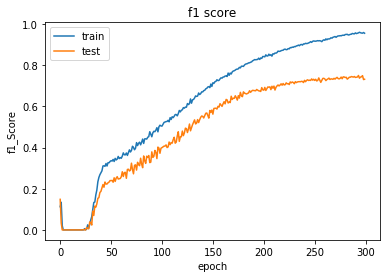

In [38]:
# summarize history for accuracy
plt.plot(history.history['fbeta_score'])
plt.plot(pd.Series(history.history['val_fbeta_score']))
plt.title('f1 score')
plt.ylabel('f1_Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [39]:
history.history['val_fbeta_score'][-1]

0.7322194576263428

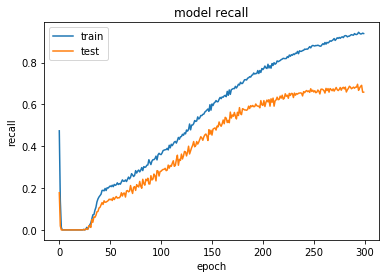

In [40]:
# summarize history for accuracy
score = 'recall'
plt.plot(history.history[score])
plt.plot(pd.Series(history.history['val_{}'.format(score)]))
plt.title('model {}'.format(score))
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [41]:
history.history['val_recall'][-1]

0.6583691239356995

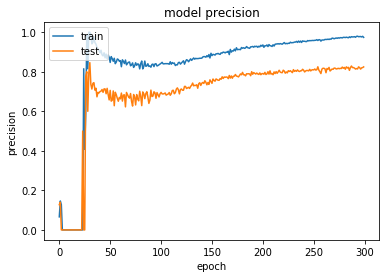

In [42]:
score = 'precision'
plt.plot(history.history[score])
plt.plot(pd.Series(history.history['val_{}'.format(score)]))
plt.title('model {}'.format(score))
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [43]:
history.history['val_precision'][-1]

0.824731171131134

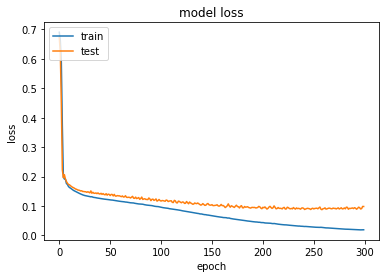

In [44]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Predict

## Euclidean Distance

from scipy.spatial import distance
a = np.array([0,0,1])
b = np.array([0, 0, 1])
dst = distance.euclidean(a, b)
dst

In [45]:
phone_arrays = {}
for phone in phones:
    phone_arrays[phone] = code(phone)
phone_arrays

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
import pickle
phone_arrays = {}
for phone in phones:
    phone_arrays[phone] = code(phone)
phone_arrays
with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'wb') as file:
    pickle.dump(phone_arrays, file, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'rb') as file:
    phone_arrays = pickle.load(file)

In [60]:
phone_arrays

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [88]:
def find_closest_array(predicted):
    """
    Find closest array.
    
    Parameters:
    ----------   
    predicted : type array
    
    Returns:
    -------
    candidate : type string
    """
    min_dst = 10000
    candidate = ''
    import pickle 
    with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'rb') as file:
        phone_arrays = pickle.load(file)
    for phone in phone_arrays:
        dst = distance.euclidean(predicted, phone_arrays[phone])
        # finds the minimum distance first
        if dst < min_dst:
            min_dst = dst
            candidate = phone
    return candidate       
#     for phone in phone_arrays:
#             dst = distance.euclidean(predicted, phone_arrays[phone])
#             if dst == min_dst:
#                 # appends all possible candidates to a list
#                 candidates.append(phone)
#     if len(candidates) > 1:
#         return  '+'.join(candidates) 
#     else:
#         return ''.join(candidates)

In [83]:
# test if it returns 3
find_closest_array([0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,0,0])

'3'

In [84]:
# test if it returns a list
find_closest_array([.678, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0])

'PAD'

 ---

## Inference mode

In [72]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [73]:
lookup = {}
for phone in phones:
    lookup[phone] = code(phone)    

In [74]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'wb') as file:
    pickle.dump(lookup, file, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
def reverse_phone(array):
    for item in lookup:
        if np.all(array == lookup[item]):
            return item

In [76]:
coded_in[0][0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [77]:
reverse_phone(coded_in[0][0])

'A'

In [78]:
reverse_phone([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'PAD'

In [79]:
lookup

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [113]:
del lookup['PAD']

In [135]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'wb') as file:
    pickle.dump(lookup, file, protocol=pickle.HIGHEST_PROTOCOL)

In [134]:
lookup['PAD'] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [144]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'rb') as file:
    lookup = pickle.load(file)
    
def decode_sequence(input_seq, renormalize=False):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 21)) # max decoder len = 13, 21 features
    max_decoder_seq_length = 13
    
    #Populate the first character of target sequence with the start character.
    target_seq= lookup['#'].reshape(1, 1, -1)

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_verb = ''
    while not stop_condition:
        output_phones, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a phone
        if renormalize:
            sampled_phone = find_closest_array(output_phones[0, -1, :]/omega)
        else:
            sampled_phone = find_closest_array(output_phones[0, -1, :])                                               
        sampled_phone_vector = lookup[sampled_phone]
        decoded_verb += sampled_phone
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_phone == '$' or 
           len(decoded_verb) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = sampled_phone_vector.reshape(1, 1, -1)
#         target_seq = np.zeros((1, 1, num_decoder_tokens))
#         target_seq[0, 0, sampled_phone_vector] = 1.

        # Update states
        states_value = [h, c]

    return decoded_verb[:-1]

def decode_sequences(seq, renormalize=False):
    if len(seq.shape) == 3:
        return [decode_sequence(s.reshape(1,*s.shape), renormalize=renormalize) for s in seq]
    else:
        return [decode_sequence(seq.reshape(1,*seq.shape), renormalize=renormalize)]

# Test

In [148]:
pd.DataFrame([decode_sequences(x_test), decode_sequences(x_test,True)], columns=input_texts.to_list(), index=['No renorm', 'Renorm']).T

,No renorm,Renorm
sabe,sabu,vabu
ekivale,agelisu,ageliju
prove,provu,brovu
traze,traPADu,draju
pode,pOPADu,bOhu
desda,desku,dezku
idea,adiu,adiu
estrea,estreuu,estrau
da,PADPADu,Odu
sobresta,sPADPADPADrPA,zorpErsu


In [122]:
pd.DataFrame(decode_sequences(padded_in[:10]), corpus.inf_verb.to_list()[:10])

,0
Ansia,Ansiiu
odia,idiiu
pleitea,plipitiu
ins3ndia,intAnviu
sortea,sorpriu
hemedia,hemebiiu
intermedia,3npr3briviu
media,mAdiu
oLa,luu
koloka,kolkuu


In [129]:
omega = 2*padded_out.mean(axis=0).mean(axis=0)